# KMC simulation of PLD with Deep Q Learning

In this version the state function is the whole atomic coordinate box

In [1]:
#!pip install tensorflow keras

In [2]:
#!pip install tensorflow-gpu

In [3]:
import sys
import os
import numpy as np
import collections
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
#Writing some helper functions

def write_lattice_to_file(input_settings,position_vec, latt):
    #Write a new input lattice file
    #position_vec is the array containing positions of all of the atoms
    filename = input_settings['incfg_file'][0]
    new_latt_xyzs = list()
    
    for i in range(position_vec.shape[0]):
        new_latt_xyzs.append(list(['Ni', position_vec[i,0], position_vec[i,1],position_vec[i,2]]))

    new_latt = collections.OrderedDict()
    new_latt['nat'] = latt['nat']
    new_latt['box'] = latt['box']
    new_latt['xyzs'] = new_latt_xyzs

    write_latt(new_latt, filename)
    
    return 

def write_new_input_file(input_settings, filename):
    #Write a new input file, with settings laid out in the dictionary input_settings
    
    with open(filename, 'w') as fo:
        for key, val in input_settings.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)

def write_params_file(input_settings, new_parms):
    #IF you want to change parameters, use this function to write a new parameters file
    new_parms_file = input_settings['param_file']
    
    with open(new_parms_file, 'w') as fo:
        for key, val in new_parms.items():
            string_to_write = key + ": " + str(val) +'\n'
            fo.write(string_to_write)
            
def make_surface_proj(atom_box):
    #Given an atom box (matrix with 1s where atoms are), determine the surface projection
    
    surface_proj = np.zeros(shape=(atom_box.shape[0], atom_box.shape[1]))
    for i in range(surface_proj.shape[0]):
        for j in range(surface_proj.shape[1]):
            try:
                surface_proj[i,j] = np.max(np.where(atom_box[i,j,:]==1))
            except ValueError:
                surface_proj[i,j] = 0
    return surface_proj

def calc_roughness(surface_projection):
    #Calculate the roughness, given a surface projection
    N = surface_projection.shape[0]
    M = surface_projection.shape[1]
    zbar = np.mean(surface_projection)
    z_sum = 0
    for i in range(N):
        for j in range(M):
            z_sum+=((surface_projection[i,j] - zbar )**2)
    rms_roughness = np.sqrt((1.0/(N*M))*z_sum)
    return rms_roughness

def get_state_reward(sim_model):
    '''Given an input of the simulation model this function returns the state and reward'''
    #To get the final state put atoms into atom box
    arr = sim_model.kmc.get_conf()
    arr_1 = np.array(arr[0])
    full_atom_box = np.zeros([latt['box'][1],latt['box'][2],latt['box'][3] ])
    for i,j,k in arr_1:
        full_atom_box[i,j,k]=1
        
    surface_proj = make_surface_proj(full_atom_box)
    rms_val = calc_roughness(surface_proj)
    
    return full_atom_box, -1*rms_val

def run_sim_with_chosen_action(s,action,old_rate, new_rates, verbose=False):
    #Given simulation model and the action, update the rate and continue running the simulation
    
    #update the rates based on the action taken
    
    #new_rate = new_rates[action]
    '''if action<4
        new_dep_rate = new_rate
        new_diff_rate = old_rates[0]
    else:
        new_diff_rate = new_rate
        new_dep_rate = old_rates[1]'''
    new_diff_rate = old_rate[1]
    new_dep_rate = new_rates[action]
    
    s.update_rate(np.array([new_dep_rate, new_diff_rate]), verbose=verbose)
    
    end_flag = s.run_to_next_step(random_seed = np.random.randint(1,99))
    
    #Now get the state and reward
    state, reward = get_state_reward(s)
            
    return state, reward, s,end_flag

In [5]:
#Need to hold the state in memory and hten 

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
sys.path.append('..') #/Users/l2v/work/kmcsim

Import kmc simulation tools

In [8]:
from kmcsim.buildtools import make_fcc, write_latt
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim

Working directory (inputs, outputs)

In [9]:
wdir = '../data/working'

In [10]:
#cat ../data/working/params

Set up simulation box and initial configuration of the substrate (with atoms filling the whole box)

In [11]:
# make substrate: perfect FCC lattice of given dimensions
box = [16, 32, 4]
latt = make_fcc(box)

In [12]:
# extend the box in the z-direction to make space for new layers to grow
latt['box'][3] = 12

In [13]:
# write initial configuration to xyz file in the working directory
write_latt(latt, os.path.join(wdir,'ni.xyz'))

In [14]:
sim = RunSim()
sim.read(os.path.join(wdir,'kmc_2.input'))
sim.init_sim()
sim.run()

('Number of events:', array([512,   0]))
time, iteration, number of atoms
(0.0, 0, 2048)
(30.004032906919242, 3346, 3204)
(60.016907489235734, 7380, 4545)
(90.02912594115722, 12195, 5965)
End of simulation
(100.03329607057059, 12662, 6041)


In [15]:
arrs=[]
sim = RunSim()
sim.read(os.path.join(wdir,'kmc_2.input'))
sim.init_sim()
sim.update_rate(np.array([0.12, 0.12]))
for k in range(100):
    sim.run_to_next_step()
    arr = sim.kmc.get_conf()
    arr_1 = np.array(arr[0])
    arrs.append(arr_1)

    if k%10==0:
        print(k)
    

('Number of events:', array([512,   0]))
current rates:[0.1 0.1] 
new rates:[0.12 0.12]
('kmc step:', 0)
0
10
20
30
40
50
60
70
80
90


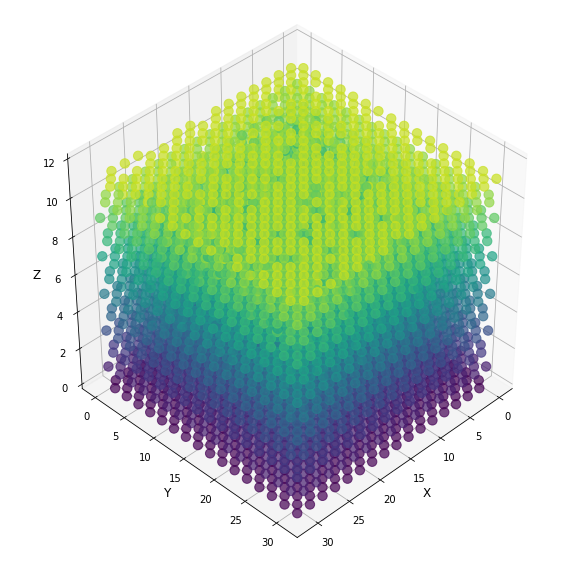

In [19]:
import os
figure_dir = r'Figures/'

arr_1 = arrs[-1]
colors = plt.cm.get_cmap('viridis', arr_1[:,2].max()*1.25)

for ind in range(100):
    plt.close('all')
    arr_1 = arrs[ind]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(arr_1[:,0],arr_1[:,1],arr_1[:,2],s=88, alpha = 0.7, c = colors(arr_1[:,2]) )
    ax.view_init(40, 45)
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.set_zlabel('Z', fontsize = 12)
    ax.set_zlim([0,12])
    fig.savefig(os.path.join(figure_dir,'Frame {}'.format(ind)), dpi = 300)
#fig2.tight_layout()